In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import nnls
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import cKDTree

# Get euclidean distance of each pair of points
def getDistance(x, xk):
    difference = x.reshape(-1, 1) - xk.reshape(1, -1)
    return np.sqrt(difference**2)

# Gaussian radial basis function
def gaussRBF(radius, sigma, eps=1e8):
    if sigma.dtype != np.float64:
        sigma[sigma==0] = eps
    coeff = 1/(sigma*(2*np.pi)**0.5)
    return coeff * np.exp(-0.5*(radius / sigma)**2)

# Gaussian Particles

We begin by defining a class for Guassian Particles. Here we provide two methods for initialising the particles, the first method initiates evenly distributed particles with equal weights, thus resulting in a relatively flat landscape within the specified bounds. 

The second method initiates the terrain based on some given input data, the particles locations is specified by $x$, and the weights are set to fit the $y$ cordinates of the input data. This method is based on RBF (Radial Basis Function) interpolation, and let's us define an initial landscape. A potential problem with this approach is that all particles end up having different weights (mass) associated with them, which could cause complications when we later move the particles for our tectonic plate simulations. A better solution would be to fit the particles to the data by specifying the $x$ coordinates of the particles, and setting their weights to a constant. As of writting, I have not yet attempted this.

The function *evaluate()* calculates the final terrain that the particles form, which can be evaluated from any $x$ coordinate.

In [2]:
class GaussParticles:

    # Initiate gaussian particles with a flat terrain
    def initFlat(self, height=1, numParticles=100, bounds=[0, 1], smoothness=2):
        self.x = np.linspace(bounds[0], bounds[1], numParticles)
        self.w =  height * (bounds[1] - bounds[0]) / numParticles
        self.initSpacing = self.x[1] - self.x[0]
        self.std = smoothness * self.initSpacing 
        self.xEval = np.copy(self.x)
        self.numParticles = numParticles
        return self
    
    # Use RBF to initiate particles by fitting them from data
    def initFromData(self, x, y, smoothness=2):
        self.x = x
        self.y = y
        self.numParticles = len(x)
        self.std = smoothness * (x[1] - x[0])
        self.xEval = np.copy(self.x)

        # Compute RBF to get weights of particles
        dist = getDistance(self.x, self.x)
        RBF = gaussRBF(dist, self.std)
        self.w, _ = nnls(RBF, self.y)
        return self

    # Evaluate the resulting heightmap at points xEval by summing all particles
    def evaluate(self, xEval=None, x=None):
        if type(xEval) == type(None):
            xEval = self.xEval
        if type(x) == type(None):
            x = self.x
        dist = getDistance(xEval, x)
        RBF = gaussRBF(dist, self.std)
        self.particles = self.w * RBF
        self.y = np.sum(self.particles, axis=1)
        return self.y

We can either initiate the particles from input data, or we can initiate a flat terrain. We can also evaluate the particles from any given set of points.

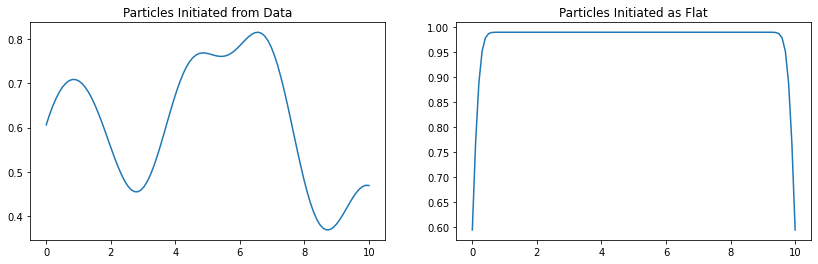

In [3]:
# Initiate with Random Data
numParticles = 20
x = np.linspace(0, 10, numParticles)
y = np.random.random(numParticles)
F = GaussParticles().initFromData(x, y)

# Initiate particles as flat terrain
G = GaussParticles().initFlat(height=1, numParticles=100, bounds=[0, 10], smoothness=2)

# Evaluate from any given set of coordinates x
xEval = np.linspace(0, 10, 100)

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(xEval, F.evaluate(xEval=xEval))
ax[1].plot(xEval, G.evaluate(xEval=xEval))
ax[0].set_title('Particles Initiated from Data')
ax[1].set_title('Particles Initiated as Flat')
plt.show()

# Moving The Particles

Moving the particles is easy, we simply adjust their $x$ coordinates. Note that within our current frame work, we do not have negative mass, and so our particles can not represent negative distributions. When representing plate tectonics, we want zero to be somewhere bellow sea level, perhaps the maximum depth of oceans, or the center of vertical mass of tectonic plates. We can offset this after evaluating the particles to represent height above/bellow sea level.

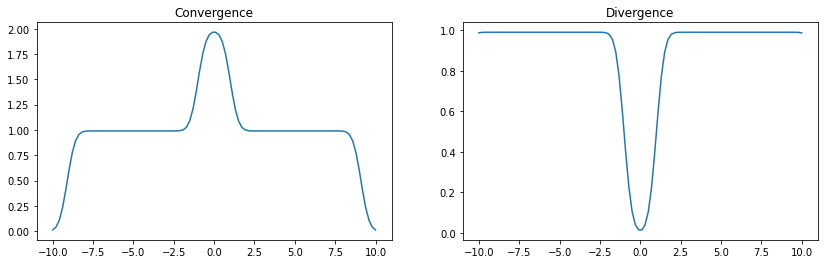

In [4]:
# Initiate flat particles
F = GaussParticles().initFlat(bounds=[-10, 10], smoothness=2)
G = GaussParticles().initFlat(bounds=[-10, 10])

# Move particles
dx = 1.0
F.x = F.x - np.sign(F.x) * dx
G.x = G.x + np.sign(G.x) * dx

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(F.xEval, F.evaluate())
ax[1].plot(G.xEval, G.evaluate())
ax[0].set_title('Convergence')
ax[1].set_title('Divergence')
plt.show()

# Particle Simulator

The particle simulator handles time related parameters for our simulation, runs the simulation, provides a useful framework to easily specify which forces to include in a simulation, and creates plots of the landscape and particle positions over time. This framework will simplify our workflow greatly, and is worth prototyping here before I move onto the spherical case.

In [5]:
class ParticleSimulator:
    def __init__(self, particles, dt=0.1, finalTime=6, forces=None):

        # Time related parameters
        self.dt = dt
        self.finalTime = finalTime
        self.iterations = int(finalTime//dt) + 1
        self.time = np.linspace(0, finalTime, self.iterations)

         # Particles related parameters
        self.particles = particles
        self.xHist = np.zeros((self.iterations, particles.numParticles))

        # Use default forces if none other is specified
        # Forces should be as list of different callable force type objects
        if type(forces) == type(None):
            self.forces = [
                ConvergenceForce(speed=2),
            ]
        else:
            self.forces = forces
    
    # This gets called every simulation iteration
    def simulationIteration(self):
        self.dx = np.zeros(self.particles.x.shape)
        for force in self.forces:
            frce = force(self)
            self.dx += frce
        self.particles.x += self.dx
    
    # Run the simulation
    def runSimulation(self):
        for i, t in enumerate(self.time):
            self.xHist[i] = self.particles.x
            self.simulationIteration()
    
    # Get plot of historical landscape
    def getHistoricLandscapePlot(self, ax):
        for i, x in enumerate(self.xHist):
            c = i / len(self.xHist)
            heightMap = self.particles.evaluate(x=x)
            ax.plot(self.particles.xEval, heightMap, color=[c, 0.0, (1 - c)])
        ax.set_title('Historical Landscape')
        ax.set_xlabel('Position x')
        ax.set_ylabel('Height')
        return ax
    
    # Plot for visualizing the historical positions of particles
    def getHistoricalParticlePositionPlot(self, ax):
        for x in self.xHist.T:
            ax.plot(x, self.time, 'b', linewidth=0.8)
        bounds = [np.min(self.particles.xEval), np.max(self.particles.xEval)]
        ax.set_xlim(bounds)
        ax.set_ylim([self.finalTime + 0.2, -0.2])
        ax.set_title('Historical Location of Particles')
        ax.set_xlabel('Position x')
        ax.set_ylabel('Time')
        return ax

# Forces

We will create a new class for each force, which contains all the parameters and functions relevant to this force. To make a force class compatible with our simulator, it must have a *\__call__()* function with the simulator as input and *dx* as output. The simulator then simply takes a list of forces as input.

Bellow is a simple example force that causes particles to move towards the origin (converge), and a demonstration of how to run a simulation.

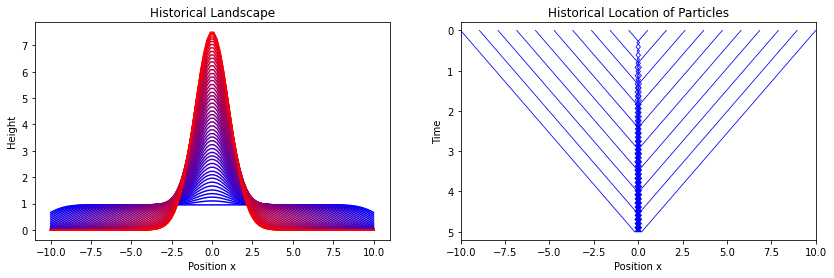

In [6]:
# A force for making particles move towards the origin
class ConvergenceForce:
    def __init__(self, speed=2):
        self.speed = speed

    # This function is required by all force type classes
    def __call__(self, simulator):
        parts = simulator.particles
        return - np.sign(parts.x) * self.speed * simulator.dt

# List of forces to be used in this simulation
forces = [
    ConvergenceForce(speed=2)
]

# Set up particles as a flat terrane
bounds = [-10, 10]
particles = GaussParticles().initFlat(bounds=bounds, numParticles=20, smoothness=1)

# Set up particle simulator and run simulation
sim = ParticleSimulator(particles, forces=forces, dt=0.1, finalTime=5)
sim.runSimulation()

# Plot resulting landscapes and particle positions
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sim.particles.xEval =  np.linspace(bounds[0], bounds[1], 100)
ax[0] = sim.getHistoricLandscapePlot(ax[0])
ax[1] = sim.getHistoricalParticlePositionPlot(ax[1])
plt.show()

## Repulsive Force

We use a repulsive force that makes particles move away from each other, which makes mountains collapse under their own weight. Given the distance $|r|$ that two particles are away from each other, the magnitude of the repulsive force is given by:

$$
dr = \frac{\alpha}{\beta |r|^3 + \epsilon}
$$

Here $\alpha$ controls the overall force magnitude, $\beta$ controls the range of the forces, and $\epsilon$ is used to avoid division by zeros.

Note that the impact that this force has on the behaviour of our particles changes greatly depending on how close the particles are to each other on average. So in the spherical case, changing the resolution of the sphere (thus changing the density of particles) will also impact the impact of this force. To avoid this issue in the spherical case, we can set the radius of the sphere such that the average distance between particles remains constant, regardless of the resolution.

When particles move too far away from each other, the individual gaussian particles become visible and the terrain is no longer smooth. In the 1 dimensional case, particles can move an unlimited distance away from each other, and so this problem is more apparent compared to in the spherical case where particles positions are limited to the surface of a sphere. We can also increase the smoothness (standard deviation) of our particles to get a smoother terrain. In the future, we might be interested in dynamically changing the standard deviation of each gaussian particle.

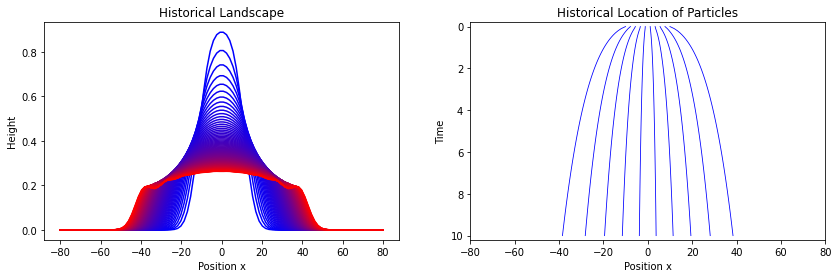

In [7]:
# Repulsive force
class RepulsiveForce:
    def __init__(self, forceMag=4, rCoeff=1e1, eps=1e-1):
        self.forceMag = forceMag
        self.rCoeff = rCoeff
        self.eps = eps

    def __call__(self, simulator):
        parts = simulator.particles
        diagonals = np.diag_indices(parts.numParticles)

        # Calculate distances, and set 0 diagonal r's to a large number
        r = parts.x.reshape(-1, 1) - parts.x.reshape(1, -1)

        # Calculate force
        dr = self.forceMag / (self.rCoeff * np.abs(r)**3 + self.eps)
        dr = dr * np.sign(r)
        dr[diagonals] = 0
        return np.sum(dr, axis=1) * simulator.dt

# List of forces to be used in this simulation
forces = [
    RepulsiveForce(forceMag=1, rCoeff=0.001, eps=0.1)
]

# Changing the density of particles changes results significantly
bounds = [-10, 10]
numParticles = 10

# Set up particles as a flat terrane
particles = GaussParticles().initFlat(bounds=bounds, numParticles=numParticles, smoothness=2)

# Set up particle simulator and run simulation
sim = ParticleSimulator(particles, forces=forces, dt=0.1, finalTime=10)
sim.runSimulation()

# Plot resulting landscapes and particle positions
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sim.particles.xEval =  np.linspace(bounds[0]*8, bounds[1]*8, 100)
ax[0] = sim.getHistoricLandscapePlot(ax[0])
ax[1] = sim.getHistoricalParticlePositionPlot(ax[1])
plt.show()

## Convergence and Repulsive Forces

In the code bellow, we combine a repulsive force with tectonic plate convergence. This causes the formation of plateaus.

If two particles are brought very close to each other, then the repulsive force might explode in magnitude, and so the particles may jump a huge distance. A simple way to solve this problem is to set a speed limit on how fast particles can move in a single iteration, which is done in the code bellow.

A much better solution would be to introduce particle collision, so that particles can never move closer to each other than some specified distance. This would make it easier to specify a maximum plateau height limit, by limiting the particle density, we will also be limiting the maximum height that a landscape can grow towards. This would also allow us to specify a repulsive force that is independent of mountains collapsing under their own weight (erosion).

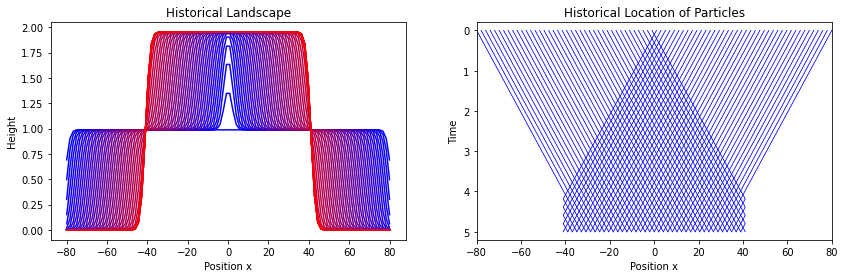

In [8]:
# Set a maximium step size dx that particles can take
class SpeedLimit:
    def __init__(self, maxSpeed=10):
        self.maxSpeed = maxSpeed

    def __call__(self, simulator):

        # Get copy of current dx and set current dx to zeros
        dx = np.copy(simulator.dx)
        simulator.dx = np.zeros(simulator.dx.shape)

        # Return dx with max speed applied
        maxDx = self.maxSpeed * simulator.dt
        dx[dx > maxDx] = maxDx
        dx[dx < -maxDx] = -maxDx
        return dx

# List of forces to be used in this simulation
forces = [
    ConvergenceForce(speed=10),
    RepulsiveForce(forceMag=4, rCoeff=1000, eps=1e-1),
    
    # Comment this line to see problem
    SpeedLimit(maxSpeed=10)
]

# Set up particles as a flat terrane
bounds = [-80, 80]
particles = GaussParticles().initFlat(bounds=bounds, numParticles=80, smoothness=1)

# Set up particle simulator and run simulation
sim = ParticleSimulator(particles, forces=forces, dt=0.1, finalTime=5)
sim.runSimulation()

# Plot resulting landscapes and particle positions
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sim.particles.xEval =  np.linspace(bounds[0], bounds[1], 100)
ax[0] = sim.getHistoricLandscapePlot(ax[0])
ax[1] = sim.getHistoricalParticlePositionPlot(ax[1])
plt.show()